# QICK-DAWG Demo Notebook (Johns Version) <a class="anchor" id="top">

## Table of Contents
0. [Initialize Notebook](#first-bullet)<br>
1. [Photoluminescence (PL) Intensity](#second-bullet) <br>
2. [Optically Deteceted Magnetic Resonance (ODMR) Spectrum](#third-bullet)<br>
3. [Rabi Oscillations](#fourth-bullet)<br>
4. [T<sub>1</sub> Delay Sweep](#fifth-bullet)<br>
5. [Useful Commands](#sixth-bullet)<br>
6. [Random Scraps of Code](#seventh-bullet)<br>

### Instructions

TODO

# [0. Initialize Notebook](#top) <a class="anchor" id="first-bullet"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serial
from copy import copy
import qickdawg as qd
from scipy.optimize import curve_fit
import scipy

qd.start_client('128.252.134.24')

#Define useful times
min_step_us = qd.soccfg.cycles2us(1) # this is the minimum step size in us, which is the time for one clock cycle
min_step_ns = min_step_us*1e3
max_int_time_us = min_step_us * (2**16 - 1)
max_int_time_ns = min_step_ns * (2**16 - 1)

#Set default expirimental configurations
default_config = qd.NVConfiguration()

default_config.adc_channel = 0
default_config.adc_trigger_offset_treg = 177
default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.laser_power = 5
default_config.laser_gate_pmod = 0
default_config.switch_pmod = 1
default_config.pre_init = True
default_config.relax_delay_tns = 500

#Set to True if computer is connected to the laser by USB
default_config.usb_connect = True

#Set the configurations to define what 'zero' is for each measurment
zero_callibration = copy(default_config)
zero_callibration.readout_integration_tus = max_int_time_us
zero_callibration.reps = 500
zero_callibration.mw_gain = 0

#Connect to the laser by usb if usb_connect is True
if default_config.usb_connect:
    ser = serial.Serial(port = "/dev/cu.usbserial-A10O10L5", 
                        baudrate = 9600, 
                        stopbits = 1, 
                        bytesize=8, 
                        parity='N', 
                        xonxoff= True)
    ser.write(b'*ON\r')
    ser.write(b'LAS\r')

# [1. Photoluminescence (PL) Intensity](#top) <a class="anchor" id="second-bullet"></a>

### PL Live Plot

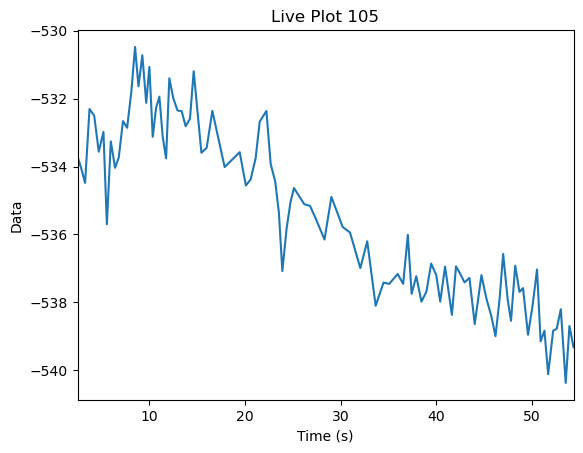

In [ ]:
pl_config = copy(default_config)

pl_config.relax_delay_tns = 5 # between each rep, wait for everything to catch up, mostly aom
pl_config.readout_integration_treg = 2**16-1 # Maxium number of integrated points
pl_config.reps = 500
pl_config.mw_gain = 30000

prog = qd.PLIntensity(pl_config)

func = lambda : prog.acquire(progress=False)

qd.live_plot(func)

# [2. Optically Deteceted Magnetic Resonance (ODMR) Spectrum](#top) <a class="anchor" id="third-bullet"></a>

### Initialize ODMR Program

In [13]:
config_odmr = copy(default_config)

#Timing
config_odmr.readout_integration_tus = max_int_time_us
config_odmr.adc_trigger_offset_tus = 25
config_odmr.relax_delay_tus = 5

#Expirimental variables
config_odmr.mw_gain = 30000
config_odmr.laser_power = 1
config_odmr.add_linear_sweep('mw', 'fMHz', start=2700, stop=3000, delta=2)

#Repetitions
config_odmr.reps = 1000

config_odmr.mw_nqz = 1

#Set laser power
if default_config.usb_connect:
    ser.write(bytearray('PWR' + str(config_odmr.laser_power) + '\r', 'ascii'))

#Find value of 'zero'
zero = qd.PLIntensity(zero_callibration).acquire()
print(zero)

-639.748681528954


### Run ODMR Program

In [14]:
prog_odmr = qd.LockinODMR_johns(config_odmr)
d_odmr = prog_odmr.acquire(progress = True, zero = zero)

  0%|          | 0/302000 [00:00<?, ?it/s]

### Plot ODMR Data

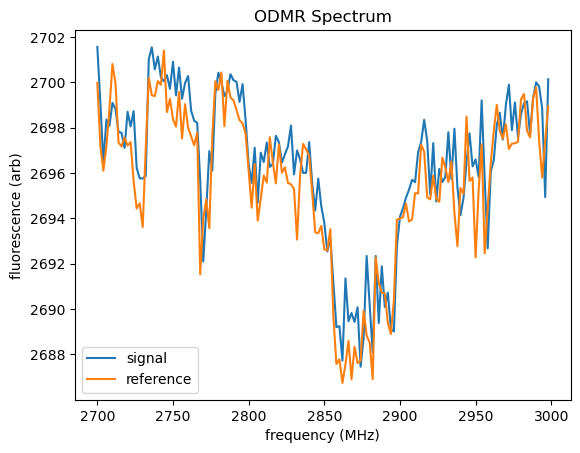

contrast is roughly 0.4396511801211007 %
The peak contrast is at roughly 2862.0 MHz


In [15]:
n = 0 #cutoff first n elements of data to plot as sometimes the first data points are wack

t = d_odmr.frequencies[n:-1]
x1 = d_odmr.signal[n:-1]
x2 = d_odmr.reference[n:-1]

plt.plot(t, x1, label='signal')
plt.plot(t, x2, label='reference')

plt.title('ODMR Spectrum')
plt.ylabel('fluorescence (arb)')
plt.xlabel('frequency (MHz)')
plt.legend()

plt.show()

# print a rough estimation of the contrast
contrast = (np.average(d_odmr.signal[1:25]) - d_odmr.reference[np.argmax(-d_odmr.reference)])/np.mean(d_odmr.signal)*100
print('contrast is roughly ' + str(contrast) + ' %')

# print frequency of largest peak
peak = d_odmr.frequencies[np.argmax(-d_odmr.reference[0:320])]
print('The peak contrast is at roughly ' + str(peak) + ' MHz')

### Save ODMR Data

In [ ]:
prog_odmr.save(data = d_odmr,
          folder_path = '/Users/osmium/ODMR measurments',
          folder_name = 'Clear Dimaond ODMR!',
          additional_configs = [['Measurment device', 'SPD'],
                                ['Sample', 'Clear Diamond'],
                                ['Objective', '20x']])

### ODMR Live Plot

In [ ]:
def get_spectrum():
    d = prog.acquire()
    print(d.signal[0] - d.signal[np.argmax(-d.signal)])
    return d.frequencies, d.signal

qd.live_plot(get_spectrum)

# [3 Rabi Oscillations](#top) <a class="anchor" id="fourth-bullet"></a>

### Initialize Rabi Program

In [ ]:
config_rabi = copy(default_config)

#Timing
config_rabi.adc_trig_offset_tus = 0
config_rabi.mw_delay_tus = 5
config_rabi.relax_delay_tus = 5
config_rabi.laser_initialize_tus = 500
config_rabi.readout_integration_tus = 2

#Expirimental variables
config_rabi.mw_gain = 30000
config_rabi.mw_fMHz = 2806.0
config_rabi.laser_power = 8
config_rabi.add_linear_sweep('mw', 'treg', start=3, stop=800, delta=5)

#Repetitions
config_rabi.reps = 500

#Set laser power
if default_config.usb_connect:
    ser.write(bytearray('PWR' + str(config_rabi.laser_power) + '\r', 'ascii'))

#Find value of 'zero'
zero = qd.PLIntensity(zero_callibration).acquire()
print(zero)

### Run Rabi Program

In [ ]:
prog_rabi = qd.RabiSweep_johns(config_rabi)
d_rabi = prog_rabi.acquire(progress=True, zero = zero)

### Plot Rabi Oscillations

In [ ]:
t = d_rabi.sweep_tus
x = d_rabi.signal

plt.plot(t, x, label='signal')

plt.legend()
plt.title('Rabi Oscillations')
plt.ylabel('PL Intensity (arb)')
plt.xlabel('pulse time (us)')
plt.show()

In [ ]:
t = d_rabi.sweep_tus
x = d_rabi.signal

plt.plot(t, x, label='signal')

plt.legend()
plt.title('Rabi Oscillations')
plt.ylabel('PL Intensity (arb)')
plt.xlabel('pulse time (us)')
plt.show()

### Fit Rabi Oscillations to Decaying Cosine

In [ ]:
def decaying_cos(x, A, T, y0, tau):

    return A*(np.cos(x*2*np.pi/T))*np.exp(-x/tau) + y0


p0 = [5, 0.7, 1520, 0.8]

t = np.linspace(d_rabi.sweep_tus[5::], 100)
x = np.linspace(d_rabi.signal[5::], 100)

param, _ = curve_fit(decaying_cos, t, x, p0 = p0, maxfev = 200000)

plt.plot(t, x)

plt.plot(t, decaying_cos(t, *param), linewidth=4)
plt.ylabel('Difference')
plt.xlabel('time (us)')
print('Pi/2 pulse is approximately {:.0f} ns'.format(param[1]*1000/4))

### Save Rabi Oscillations

In [ ]:
prog_rabi.save(data = d_rabi,
          folder_path = '/Users/osmium/Rabi measurments',
          folder_name = 'Purple diamond long laser on time test',
          additional_configs = [['Measurment device', 'APD'],
                                ['Sample', 'Purple Diamond'],
                                ['Objective', '20x']])

# [4. T<sub>1</sub> Delay Sweep](#top) <a class="anchor" id="fifth-bullet"></a>

### Initialize T<sub>1</sub> Program

In [ ]:
# exponential scaling

config_t1 = copy(default_config)

#Timing
config_t1.laser_on_tus = 300
config_t1.readout_integration_tus = 1
config_t1.readout_reference_start_tus = 250
config_t1.laser_readout_offset_tus = 0.44
config_t1.mw_readout_delay_treg = 50

#Expirimental variables
config_t1.mw_gain = 30000
config_t1.mw_fMHz = 3140
config_t1.mw_pi2_tns = 277
config_t1.add_exponential_sweep('delay', 'tus', start=1, stop=10000, scaling_factor='3/2')

#Repetitions
config_t1.reps=1000

#Set laser power
if default_config.usb_connect:
    ser.write(bytearray('PWR' + str(config_t1.laser_power) + '\r', 'ascii'))

#Find value of 'zero'
zero = qd.PLIntensity(zero_callibration).acquire()
print(zero)

### Run T<sub>1</sub> Program

In [ ]:
prog_t1 = qd.T1DelaySweep(config_t1)
d_t1 = prog_t1.acquire(progress=True, zero = zero)

### Plot T<sub>1</sub> Data

In [ ]:
p0 = [0.6, 5e3, 0]

t = d_t1.sweep_tus
x = d_t1.contrast

plt.plot(t, x)
#plt.plot(t, qd.exponential_decay(t, *p0))

param, _ = curve_fit(qd.exponential_decay, t, x, p0)
plt.plot(t, qd.exponential_decay(t, *param))

plt.xscale('log')
# plt.xlim(1, )
print('T1 is approximatel {:0f} ms'.format(param[1]/1e3))
plt.title('T1 Relaxation')
plt.ylabel('Contrast (%)')
plt.xlabel('Delay (us)')
plt.show()

### Save T<sub>1</sub> Data

In [ ]:
prog_t1.save(data = d_t1,
             folder_path = '/Users/osmium/T1 measurments',
             #folder_name = 'Purple diamond capacitor test',
             additional_configs = [['Measurment device', 'SPD'],
                                ['Sample', 'Purple Diamond'],
                                ['Objective', '20x']])

# [5. Helpful Commands](#top) <a class="anchor" id="sixth-bullet"></a>

In [4]:
ser.write(b'\rPWR1\r')

6

In [17]:
qd.laser_on(default_config)

-207.50392156862745

In [4]:
qd.laser_off(default_config)

4595.8492103456165

# [6. Random Scraps of Code](#top) <a class="anchor" id="seventh-bullet"></a>

In [ ]:
zero = 675

num_expts = 10

d_odmr_signal = np.zeros([num_expts,config.nsweep_points])
d_odmr_reference = np.zeros([num_expts,config.nsweep_points])

for i in range(0, num_expts):
    prog = qd.LockinODMRImproved(config)
    d = prog.acquire(progress = True, zero = zero)
    d_odmr_signal[i] = d.signal
    d_odmr_reference[i] = d.reference
    d_domr_frequencies = d.frequencies

d_odmr_signal = d_odmr_signal.mean(axis = 0)
d_odmr_reference = d_odmr_reference.mean(axis = 0)